In [239]:
import heapq
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt

In [240]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    ****************
    Definition of an event in this model:
    1. A passenger's arrival
    2. A passenger gets off the bus
    3. A bus arrives at the station
    
    Overall functionality: 
    For an event, if its schedule time is less than the current time, then it happens.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)

class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [241]:
class uniform:
    '''
    Generate a list ranging from 1 to n (i.e. the input parameter).
    rvs() method randomly choose a number from the list as the number of stops the passenger stays on bus.
    '''
    def __init__(self, n):
        self.__list = [i+1 for i in range(n)]
    
    def rvs(self):
        return np.random.choice(self.__list)

            
class Station(Event):
    '''
    Functionality:
    1. record the passengers' arrival time 
    2. record/count the passengers' waiting time at the station
    3. calculate the number of passengers at the station (queue lengths)
    '''
    def __init__(self,name,arrival_distribution,leave_distribution):
        self.wait_people = 0
        self.leave_distribution = leave_distribution
        self.arrival_distribution = arrival_distribution
        self.leave_queue = [] # Passengers' destination
        self.wait_time = 0
        self.name = name # The index of the stop
        self.max_wait_people = 0
        self.transportation_people = 0
    
    # Update the queue lengths
    def update_wait_people(self,num):
        self.wait_people += num
        self.transportation_people += num
    
    def update_wait_time(self, time):
        self.wait_time += self.wait_people*time
    
    # Count how many passengers arrived over a period of time
    def add_customer(self, time):
        n = 0
        arrive_time = []
        now_time = self.arrival_distribution.rvs()
        arrive_time = list_sum(arrive_time,now_time)
        n += 1
        # If the last arrival is smaller than the time the bus drops all passengers
        while arrive_time[-1] <= time:
            now_time = sts.expon(scale=1).rvs()
            arrive_time = list_sum(arrive_time,now_time)
            n += 1
        self.wait_time += np.sum(time - np.array(arrive_time[:-1]))
        # Record the max queue length by comparing each update with the previous max queue length
        self.max_wait_people =(self.wait_people)+n-1 if (self.wait_people)+n-1>self.max_wait_people else self.wait_people
        #print(f'After{time} minutes, {n-1} passegners arrived at No.{self.name} Stop | Total: {self.wait_people+n-1}')
        # We need to subtract 1 to get the real number
        return n-1
    
    def update_boarding_people(self, boarding_num):
        self.wait_people -= boarding_num
    
    # Update the destination record
    def update_leave_people(self, n):
        [self.leave_queue.append(self.leave_distribution.rvs()) for i in range(n)]
        self.wait_people -= n
        #print(f'No.{self.name} Stop reduced {n} waiting passengers')

In [242]:
# Help calculate the arrival time points
def list_sum(list_, x):
    if len(list_) == 0:
        return [x]
    else:
        list_.append(list_[-1] + x)
        return list_

In [243]:
class Bus(Event):
    def __init__(self, name, max_people, where_, boarding_parameter, get_off_parameter, bus_arrive_distribution):
        # Initialize parameters
        self.arrive_next_time = 0
        self.arrive_next_put = 0        
        self.arrive_next_get = 0
        self.boarding_parameter = boarding_parameter
        self.get_off_parameter = get_off_parameter
        self.bus_arrive_distribution = bus_arrive_distribution
        self.now_people = 0
        self.max_people = max_people
        self.bus_where = where_ # The location of the bus
        # Checks for getting off
        # e.g., if there are 10 zeros, 10 people get off the bus
        self.priority_queue = [] 
        self.frequency = uniform(7)
        self.name = name # The index of the bus
        self.seat_occupation = []
    
    # Passengers get off the bus
    def update_people_leave(self):
        return_data = int(np.sum([True if i == 0 else False for i in self.priority_queue]))
        self.now_people -= return_data
        self.priority_queue = [x for x in self.priority_queue if x != 0]
        #print(f'No.{self.name} Bus arrived No.{self.bus_where} Stop, dropping {return_data} passengers')
        return int(return_data)
    
    # Update the traveling time from the current stop to the next stop
    # To avoid the conflict of simultaneous bus arrivals, 
    # I considered the bus arrival time point as when the bus has traveled and has dropped passengers.
    def get_next_time(self, n):
        self.arrive_next_time =self.bus_arrive_distribution.rvs()+ sts.norm(loc=self.get_off_parameter[0]*n, 
                                                                       scale=self.get_off_parameter[1]*(n**0.5)).rvs()
    
    def update_next_time(self, time):
        self.arrive_next_time -= time
    
    # Update how many people the bus picks up
    def update_bus_people(self, site_people):
        # There are enough empty seats for this group of people to get on. 
        if self.max_people - self.now_people >= site_people:
            self.now_people += site_people
            [self.priority_queue.append(self.frequency.rvs()) for i in range(site_people)]
            # Calculate the seat occupation rate
            self.seat_occupation.append(self.now_people / self.max_people)
            return site_people, sts.norm(loc=self.boarding_parameter[0]*site_people, scale=self.boarding_parameter[1]*(site_people**0.5)).rvs()
        # The remaining seats < the number of people who want to get on
        else:
            return_site_people = self.max_people - self.now_people
            [self.priority_queue.append(self.frequency.rvs()) for i in range(int(self.max_people - self.now_people))]
            self.now_people = self.max_people
            # The bus is completely filled up
            self.seat_occupation.append(1)
            return int(return_site_people), sts.norm(loc=self.boarding_parameter[0]*(self.max_people - self.now_people),
                                                scale=self.boarding_parameter[1]*((self.max_people - self.now_people)**0.5)).rvs()
    
    # Update the location of the bus
    def update_where(self, max_where):
        self.bus_where = self.bus_where + 1 if self.bus_where != max_where - 1 else 0
        #print(f"No.{self.name} Bus arrived No.{self.bus_where} Stop, with {self.now_people} passengers")

In [244]:
class BusSystem(Bus, Station):
    def __init__(self, bus_num, bus_max_people, arrival_distribution, leave_distribution, station_num = 15):
        # Make the bus starting stop more uniformly distributed
        if bus_num < station_num:
            self.bus_server = [Bus(f'bus{i}', bus_max_people, i*(15/bus_num)//1, [0.05,0.01], [0.03,0.01], sts.norm(loc=2, scale=0.5)) for i in range(bus_num)]
        else:
            self.bus_server = [Bus(f'bus{i}', bus_max_people, i if i <= station_num else (i-station_num)*(15/bus_num)//1, [0.05,0.01], [0.03,0.01], sts.norm(loc=2, scale=0.5)) for i in range(bus_num)]
        self.station_server = [Station(i, arrival_distribution, leave_distribution) for i in range(station_num)]
        self.station_num = station_num
        self.all_time = 0
    
    # Initialize all the buses' location
    def update_bus_where(self):
        [i.update_where(self.station_num) for i in self.bus_server]
    
    def update_bus_next_time(self, time):
        [i.update_next_time(time) for i in self.bus_server[:]]
    
    # Update the time of bus arrival at the next stop
    def get_bus_next_time(self):
        [i.update_next_time(i.update_people_leave()) for i in self.bus_server]
    
    # Update how many passengers will be dropped when the bus arrives at the next stop
    def update_arrive_bus_people(self,num):
        [i.update_bus_people(num) for i in self.bus_server]
    
    # Update how many passengers are currently on the bus
    def update_now_people(self):
        [i.update_bus_people(num) for i in self.bus_server]
    
    # Update bus when picking up passengers
    def update_arrive_people(self,time):
        self.all_time += time
        return [i.add_customer(time) for i in self.station_server]

In [245]:
def run_simulation(bus_num, bus_max_people, service_distribution, leave_distribution, station_num, run_until):
    # Initialize the system
    model = BusSystem(bus_num, bus_max_people, service_distribution, leave_distribution, station_num)
    # Generate the traveling time to the next stop
    model.get_bus_next_time()
    
    # Within the simulation time
    while model.all_time <= run_until:
        # Sort the buses based on the time it takes to reach the next place
        model.bus_server = [model.bus_server[i] for i in np.argsort([i.arrive_next_time for i in model.bus_server])]
        # Update the queue lengths after the bus arrives and drop the passengers 
        [i.update_wait_people(j) for i,j in zip(model.station_server,model.update_arrive_people(model.bus_server[0].arrive_next_time))]
        # Update the arriving status
        model.update_bus_next_time(model.bus_server[0].arrive_next_time)
        # Calculate the number of people on the bus and the time to get on the bus
        people_num, time_ = model.bus_server[0].update_bus_people(int(model.station_server[int(model.bus_server[0].bus_where)].wait_people))
        # Update time (time when passengers boarded the bus)
        model.station_server[int(model.bus_server[0].bus_where)].update_leave_people(people_num)
        # Update record of the destination stops 
        # e.g. I planned to get off after 5 stops, after one stop, I will get off after 4 stops.
        model.bus_server[0].priority_queue = [i-1 for i in model.bus_server[0].priority_queue]
        # Update the next stop of the first bus
        model.bus_server[0].update_where(model.station_num)
        # Update the number of people waiting at the station
        [i.update_wait_people(j) for i,j in zip(model.station_server,model.update_arrive_people(time_))]
        # Update the time of arrival at the next stop
        model.bus_server[0].get_next_time(model.bus_server[0].update_people_leave())
        # Plus the time of getting on at the current station
        model.bus_server[0].arrive_next_time += time_
    return model

In [287]:
%%time
# Create empty lists to store results
all_time_list = []
all_wait_people = []
all_seat_occupation = []
all_time_mean = []
all_wait_people_mean = []
all_seat_occupation_mean = []

# Input parameters:
max_number_of_buses = 10
trials = 10
max_capacity = 130
# here the bus is operating 24h (1440min) which takes too long
# so I chose 360, to give a sufficient time period while we can get the results quickly
run_until = 360

# Calculate the expected mean & 95% CI
for n in range(1, max_number_of_buses+1): # range() the right-hand side not included
    time_list = []
    wait_list = []
    seat_occupation_list = []
    
    for num in range(trials):
        model = run_simulation(n, max_capacity, sts.expon(scale=1), uniform(7), 15, run_until)
        time_list.append(np.sum([i.wait_time/i.transportation_people for i in model.station_server]))
        wait_list.append(max([i.max_wait_people for i in model.station_server]))
        seat_occupation_list.append(np.mean([np.mean(i.seat_occupation) for i in model.bus_server]))
    
    all_time_mean.append(round(np.mean(time_list), 2))
    all_time_list.append([round(np.percentile(time_list, 2.5), 2), round(np.percentile(time_list, 97.5), 2)])
    wait_list = pd.DataFrame(wait_list)
    wait_people = wait_list[np.argmax(wait_list.mean(axis = 0))]
    all_wait_people.append([round(np.percentile(wait_people, 2.5), 2), round(np.percentile(wait_people, 97.5), 2)])
    all_wait_people_mean.append(round(np.mean(wait_people), 2))
    all_seat_occupation.append([round(np.percentile(seat_occupation_list, 2.5), 2), round(np.percentile(seat_occupation_list, 97.5), 2)])
    all_seat_occupation_mean.append(round(np.mean(seat_occupation_list), 2))
    print(f'Scenario {n} finished!')

Scenario 1 finished!
Scenario 2 finished!
Scenario 3 finished!
Scenario 4 finished!
Scenario 5 finished!
Scenario 6 finished!
Scenario 7 finished!
Scenario 8 finished!
Scenario 9 finished!
Scenario 10 finished!
CPU times: user 8min 22s, sys: 4.61 s, total: 8min 27s
Wall time: 8min 37s


In [374]:
# This cell is calculating the average service time to set up theoretical analysis.
def run_simulation(bus_num, bus_max_people, service_distribution, leave_distribution, station_num, run_until):
    # Initialize the system
    model = BusSystem(bus_num, bus_max_people, service_distribution, leave_distribution, station_num)
    # Generate the traveling time to the next stop
    model.get_bus_next_time()
    time_get_on = []
    people_get_on = []
    
    # Within the simulation time
    while model.all_time <= run_until:
        # Sort the buses based on the time it takes to reach the next place
        model.bus_server = [model.bus_server[i] for i in np.argsort([i.arrive_next_time for i in model.bus_server])]
        # Update the queue lengths after the bus arrives and drop the passengers 
        [i.update_wait_people(j) for i,j in zip(model.station_server,model.update_arrive_people(model.bus_server[0].arrive_next_time))]
        # Update the arriving status
        model.update_bus_next_time(model.bus_server[0].arrive_next_time)
        # Calculate the number of people on the bus and the time to get on the bus
        people_num, time_ = model.bus_server[0].update_bus_people(int(model.station_server[int(model.bus_server[0].bus_where)].wait_people))
        # Update time (time when passengers boarded the bus)
        model.station_server[int(model.bus_server[0].bus_where)].update_leave_people(people_num)
        # Update record of the destination stops 
        # e.g. I planned to get off after 5 stops, after one stop, I will get off after 4 stops.
        model.bus_server[0].priority_queue = [i-1 for i in model.bus_server[0].priority_queue]
        # Update the next stop of the first bus
        model.bus_server[0].update_where(model.station_num)
        # Update the number of people waiting at the station
        [i.update_wait_people(j) for i,j in zip(model.station_server,model.update_arrive_people(time_))]
        # Update the time of arrival at the next stop
        model.bus_server[0].get_next_time(model.bus_server[0].update_people_leave())
        # Plus the time of getting on at the current station
        model.bus_server[0].arrive_next_time += time_
        people_get_off = np.sum([True if i == 1 else False for i in model.bus_server[0].priority_queue])
        # the number of people to get on 
        time_get_on.append(time_) 
    return time_get_on

# Input parameters:
max_number_of_buses = 10
trials = 3
max_capacity = 130
run_until = 180

time_lst = []
std_lst = []
# Calculate the expected mean & 95% CI
for n in range(1, max_number_of_buses+1): # range() the right-hand side not included
    for num in range(trials):
        model = run_simulation(n, max_capacity, sts.expon(scale=1), uniform(7), 15, run_until)
        avg_time = np.mean(model)
        avg_std = sts.sem(model)
    time_lst.append(np.mean(avg_time))
    std_lst.append(np.mean(avg_std))
    print(n, np.mean(avg_time), np.mean(avg_std))

1 0.1756605324496542 0.06563880100320424
2 0.5456857437657285 0.08067558210081986
3 0.8406106603111214 0.07265311366264458
4 0.771849411688509 0.06464612832380749
5 0.6893751345476903 0.06003735739592138
6 0.5539133488908449 0.043678287023467544
7 0.5723891699453072 0.04128839499941597
8 0.6460955105562127 0.046811645645899146
9 0.5446739342540706 0.04756471067450287
10 0.5849121902948142 0.035199870537266705


In [375]:
def theoretical_queue_length(rho, sigma, tau):
    """
    This function is used to calculate the theoretical average queue length for M/G/1 model.
    """
    return (rho)**2 / 2 / (1-rho) * (1 + sigma**2 / tau**2)

def theoretical_wait_time(rho, sigma, tau):
    """
    This function is used to calculate the theoretical wait time for M/G/1 model.
    """
    return ((rho*tau)/(2*(1-rho))) * (1+ (sigma**2)/ (tau**2))

In [332]:
results = pd.DataFrame([[i for i in range(1,11)], all_time_mean, all_time_list,all_wait_people_mean,all_wait_people,all_seat_occupation_mean,all_seat_occupation],index = [
    'Number of Buses','Expected Average Waiting Time','Average Waiting Time 95% CI','Expected Value of Maximum Queue Length','Maximum Queue Length 95% CI','Expected Value of Seat Occupation Rate','Seat Occupation Rate 95% CI'
]).T
results

,Number of Buses,Expected Average Waiting Time,Average Waiting Time 95% CI,Expected Value of Maximum Queue Length,Maximum Queue Length 95% CI,Expected Value of Seat Occupation Rate,Seat Occupation Rate 95% CI
0,1,22.92,"[22.37, 23.28]",161.7,"[140.93, 179.65]",0.93,"[0.93, 0.94]"
1,2,15.86,"[15.45, 16.32]",61.3,"[45.35, 76.42]",0.9,"[0.89, 0.9]"
2,3,12.75,"[12.4, 13.1]",43.8,"[38.45, 52.88]",0.84,"[0.82, 0.86]"
3,4,10.93,"[9.87, 11.86]",50.4,"[33.67, 72.53]",0.64,"[0.54, 0.76]"
4,5,9.5,"[8.74, 10.38]",60.1,"[48.0, 100.93]",0.52,"[0.43, 0.64]"
5,6,9.23,"[8.37, 10.14]",75.0,"[49.9, 96.0]",0.41,"[0.37, 0.49]"
6,7,9.04,"[8.21, 10.33]",71.0,"[40.38, 99.52]",0.38,"[0.33, 0.48]"
7,8,8.89,"[7.9, 10.0]",69.1,"[55.0, 86.42]",0.35,"[0.3, 0.39]"
8,9,8.93,"[7.16, 10.08]",69.4,"[51.0, 93.32]",0.32,"[0.28, 0.38]"
9,10,9.0,"[7.71, 10.85]",66.5,"[43.7, 98.5]",0.31,"[0.26, 0.36]"


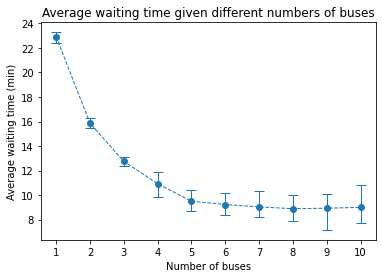

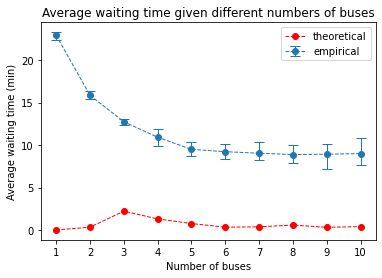

In [379]:
tau = time_lst
rho = tau # they are equal in this case since lambda = 1
sigma = std_lst

# Compute the theoretical value
theoretical_wait_time_lst = []
for i in range(10):
    theoretical_wait_time_lst.append(theoretical_queue_length(rho[i], sigma[i], tau[i]))

error = [[], []]
for i in range(len(all_time_list)):
    error[0].append(all_time_mean[i] - all_time_list[i][0])
    error[1].append(all_time_list[i][1] - all_time_mean[i])

x = range(1, 11)
plt.errorbar(x, y = all_time_mean, yerr = error, 
             marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xticks(range(1, 11))
plt.xlabel('Number of buses')
plt.ylabel('Average waiting time (min)')
plt.title('Average waiting time given different numbers of buses')
plt.show()

plt.errorbar(x, y = all_time_mean, yerr = error, 
             marker='o', capsize=5, linestyle='--', linewidth=1, label='empirical')
plt.plot(x, theoretical_wait_time_lst, color='red', marker='o', linestyle='--', linewidth=1,label='theoretical')
plt.xticks(range(1, 11))
plt.xlabel('Number of buses')
plt.ylabel('Average waiting time (min)')
plt.title('Average waiting time given different numbers of buses')
plt.legend()
plt.show()

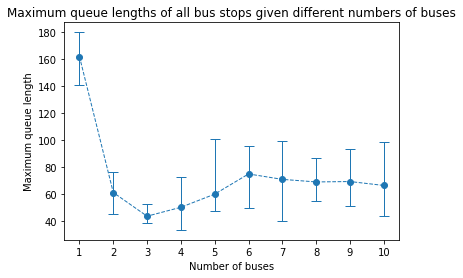

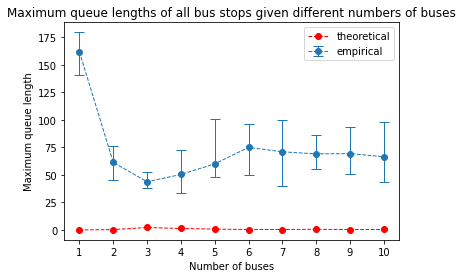

In [381]:
# Compute the theoretical value
theoretical_queue_lst = []
for i in range(10):
    theoretical_queue_lst.append(theoretical_wait_time(rho[i], sigma[i], tau[i]))
    
error = [[], []]
for i in range(len(all_wait_people)):
    error[0].append(all_wait_people_mean[i] - all_wait_people[i][0])
    error[1].append(all_wait_people[i][1] - all_wait_people_mean[i])

plt.errorbar(x = range(1, 11), y = all_wait_people_mean, yerr = error, 
             marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xticks(range(1, 11))
plt.xlabel('Number of buses')
plt.ylabel('Maximum queue length')
plt.title('Maximum queue lengths of all bus stops given different numbers of buses')
plt.show()

plt.errorbar(x = range(1, 11), y = all_wait_people_mean, yerr = error, 
             marker='o', capsize=5, linestyle='--', linewidth=1, label='empirical')
plt.plot(x, theoretical_queue_lst, color='red', marker='o', linestyle='--', linewidth=1,label='theoretical')
plt.xticks(range(1, 11))
plt.xlabel('Number of buses')
plt.ylabel('Maximum queue length')
plt.title('Maximum queue lengths of all bus stops given different numbers of buses')
plt.legend()
plt.show()

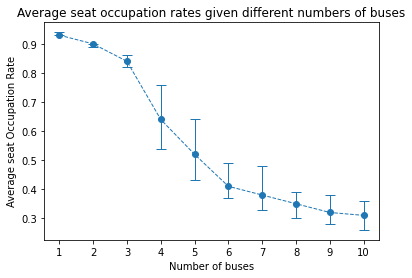

In [291]:
error = [[], []]
for i in range(len(all_wait_people)):
    error[0].append(all_seat_occupation_mean[i] - all_seat_occupation[i][0])
    error[1].append(all_seat_occupation[i][1] - all_seat_occupation_mean[i])

plt.figure()
plt.errorbar(x = range(1, 11), y = all_seat_occupation_mean, yerr = error, 
             marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xticks(range(1, 11))
plt.xlabel('Number of buses')
plt.ylabel('Average seat Occupation Rate')
plt.title('Average seat occupation rates given different numbers of buses')
plt.show()